# Store 18

- Apply three business initiatives to optimize inventory <br>
- Use pre-trained LSTM model to predict sales based on each inventory initiative <br>
- Analyze increased sales.

## Preparation

In [ ]:
STOREID = 18


In [ ]:
# Let`s import all packages:

import sys
from pathlib import Path
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from keras.models import load_model

In [ ]:
# import tensorflow as tf
# print(tf.__version__)
import keras
print(keras.__version__)

2.8.0


In [ ]:
# Created a dataframe for each product
def create_dfs(product_codes):
  dfs = []
  for code in product_codes:
    dfname = "df_" + str(code)
    dfname = df2[df2['PLU'] == code]
    dfname = dfname.drop('PLU', axis=1)
    dfs.append(dfname)
  return dfs

In [ ]:
# function to create time series data
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
	"""
	n_in: number of features to predict
	n_out: number of label to predict
	dropnan: if NaN, drop it or not
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Read original SoldQuantity data and get predictedSoldQuantity based on original coffee store SoldQuantity data

In [ ]:
# read the original coffee store data first

df_original = pd.read_csv('all_store_clean_data.csv')
df_original

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,2,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,0.0,0.0,21,0,2,0,0,3.0
1,2,2019-06-29,830620,Honey Raisin Bran Muffin,Food,Bake Case,Muffins & Scones,4.0,0.0,10,0,2,0,0,2.0
2,2,2019-06-29,6228,Pressed Juicery Spicy Greens w Ginger,Food,Cold Case,Ready to Drink,0.0,9.0,13,0,2,0,0,1.0
3,2,2019-06-29,12216,Vive Juice Shot,Food,Cold Case,Ready to Drink,0.0,27.0,0,0,2,0,0,0.0
4,2,2019-06-29,3000277,Mixed Berries & Granola Yogurt Parfait,Food,Cold Case,Ready to Eat,0.0,0.0,11,1,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259771,401,2020-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,6.0,3.0,0,0,1,1,0,3.0
1259772,401,2020-06-29,810407,Plain Bagel,Food,Bake Case,Bagels,6.0,0.0,0,1,1,1,0,6.0
1259773,401,2020-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,4.0,0.0,0,0,1,1,0,2.0
1259774,401,2020-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,6.0,0.0,0,0,1,1,0,3.0


In [ ]:
df_current_store_temp = df_original[df_original['StoreID'] == STOREID]
product_codes = [3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402]
df_current_store = df_current_store_temp[df_current_store_temp['PLU'].isin(product_codes)]
df_current_store

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,4.0,4.0,9,0,2,0,0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,Food,Cold Case,Ready to Eat,1.0,1.0,21,0,2,0,0,2.0
39468,18,2019-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,6.0,0.0,16,0,2,0,0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,8.0,0.0,16,0,2,0,0,6.0
39471,18,2019-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,8.0,0.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,Food,Cold Case,Ready to Eat,0.0,0.0,10,0,1,1,0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,Food,Bake Case,Pastries,0.0,1.0,16,0,1,1,0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,Food,Bake Case,Pastries,0.0,1.0,0,0,1,1,0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,Food,Bake Case,Cakes & Breads,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
# unique products (codes and names)

product_codes = df_current_store['PLU'].unique()
print("product_codes: " , product_codes)

PLU_description = df_current_store['Description'].unique()
print("PLU_description: ", PLU_description)

product_codes:  [3000227 3000278  820602  820801  820902  820224  810703 3000210 3000159
 3000207 3000209 3000214  841402]
PLU_description:  ['Caprese Sandwich' 'Breakfast Burrito Egg Beans & Rice'
 'Everything Bagel' 'Blueberry Scone' 'Butter Croissant'
 'Chocolate Croissant' 'Cinnamon Roll' 'Cookie - Chocolate Chunk'
 'Egg| Spinach & Cheddar Sandwich on Ciabatta' 'Danish - Classic Cheese'
 'Croissant - White Cheddar Jalapeno' 'Coffee Cake with Streusel'
 'Almond Croissant']


In [ ]:
df_current_store.index

Int64Index([39461, 39466, 39468, 39470, 39471, 39472, 39473, 39474, 39478,
            39481,
            ...
            49752, 49753, 49754, 49755, 49756, 49760, 49763, 49764, 49767,
            49769],
           dtype='int64', length=4691)

In [ ]:
df2 = df_current_store.drop(['StoreID', 'BusinessDate', 'Description', 'CategoryLvl1Desc', 'CategoryLvl2Desc', 'CategoryLvl3Desc'], axis=1)
df2

,PLU,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,3000227,4.0,4.0,9,0,2,0,0,1.0
39466,3000278,1.0,1.0,21,0,2,0,0,2.0
39468,820602,6.0,0.0,16,0,2,0,0,4.0
39470,820801,8.0,0.0,16,0,2,0,0,6.0
39471,820902,8.0,0.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...
49760,3000159,0.0,0.0,10,0,1,1,0,5.0
49763,3000207,0.0,1.0,16,0,1,1,0,2.0
49764,3000209,0.0,1.0,0,0,1,1,0,0.0
49767,3000214,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
dfs = create_dfs(product_codes)

In [ ]:
dfs[0].index  #check index is preserved

Int64Index([39461, 39488, 39515, 39541, 39566, 39594, 39621, 39647, 39674,
            39702,
            ...
            49470, 49500, 49531, 49560, 49590, 49621, 49650, 49679, 49709,
            49740],
           dtype='int64', length=367)

In [ ]:
# created a new dataframe to collect all necessary sales estimated and predicted data

df_sales = df_current_store.loc[:,['StoreID', 'BusinessDate', 'PLU', 'Description','SoldQuantity']]
df_sales

# created a dataframe to collect original data and predicted data
df_sales_0 = df_current_store.loc[:,['StoreID', 'BusinessDate', 'PLU', 'Description','ReceivedQuantity', 'EndQuantity', 'SoldQuantity']]
df_sales_0

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,4.0,4.0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,1.0,1.0,2.0
39468,18,2019-06-29,820602,Everything Bagel,6.0,0.0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,8.0,0.0,6.0
39471,18,2019-06-29,820902,Butter Croissant,8.0,0.0,7.0
...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0


Apply the prediction on the orignial sales data

**********3000227: Caprese Sandwich**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


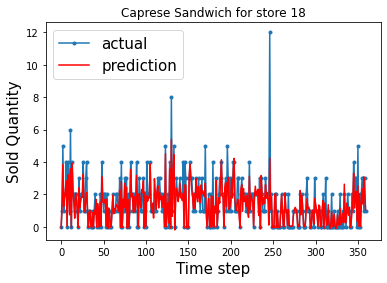

**********3000278: Breakfast Burrito Egg Beans & Rice**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


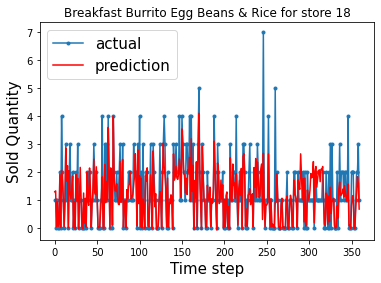

**********820602: Everything Bagel**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


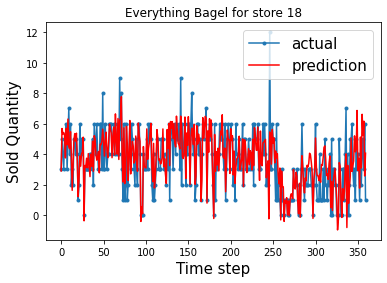

**********820801: Blueberry Scone**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


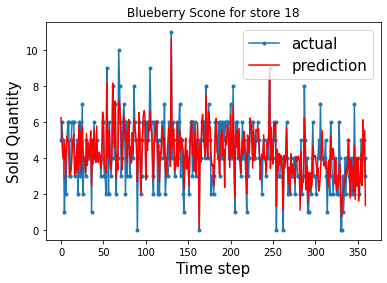

**********820902: Butter Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


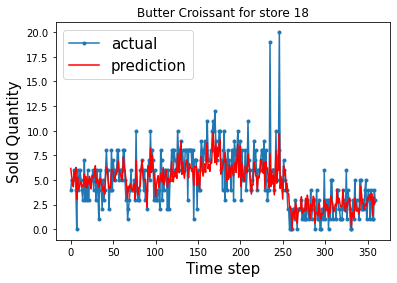

**********820224: Chocolate Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


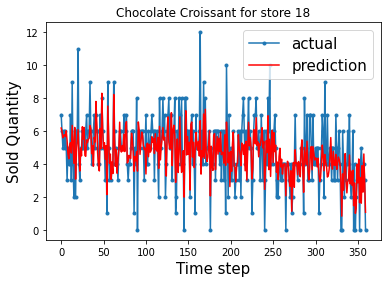

**********810703: Cinnamon Roll**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


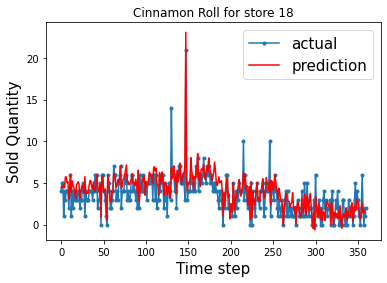

**********3000210: Cookie - Chocolate Chunk**************
time series data shape is:  (307, 64)
feature_X.shape, y.shape:  (307, 1, 63) (307,)


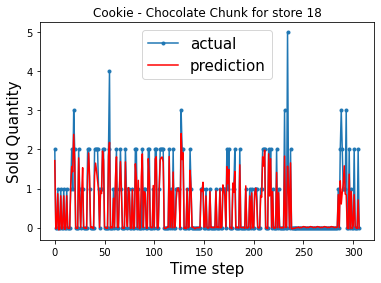

**********3000159: Egg| Spinach & Cheddar Sandwich on Ciabatta**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


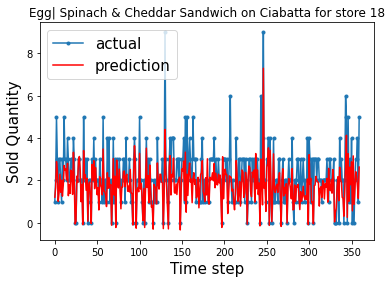

**********3000207: Danish - Classic Cheese**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


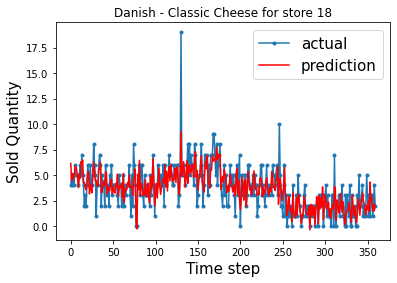

**********3000209: Croissant - White Cheddar Jalapeno**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


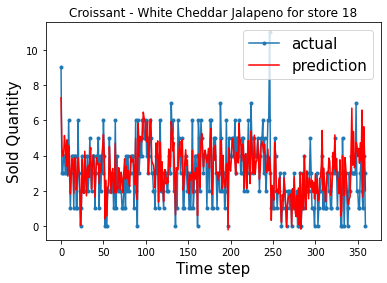

**********3000214: Coffee Cake with Streusel**************
time series data shape is:  (333, 64)
feature_X.shape, y.shape:  (333, 1, 63) (333,)


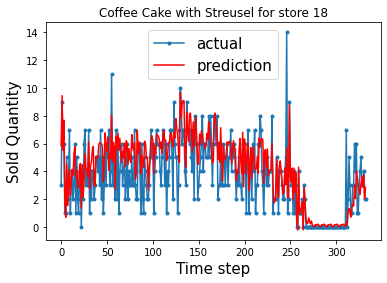

**********841402: Almond Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


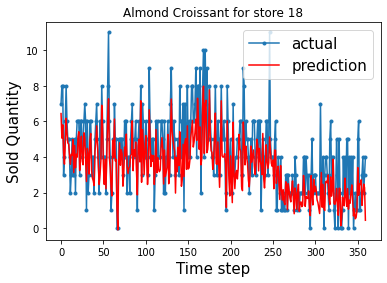

all 13 products prediction is done.


In [ ]:
# dfs = create_dfs(product_codes)

for i, df_product in enumerate(dfs):

  print(f"**********{product_codes[i]}: {PLU_description[i]}**************")

  # split into train and test sets
  values = df_product.values
  reframed = series_to_supervised(values, 7, 1)
  print("time series data shape is: ", reframed.shape)

  values = reframed.values

  # data does not contain y (SoldQuantity), load model to predict
  X, y = values[:, :-1], values[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  feature_X = X.reshape((X.shape[0], 1, X.shape[1]))

  print("feature_X.shape, y.shape: ", feature_X.shape, y.shape)

  # load model
  model = load_model(f'models_store_{STOREID}/{product_codes[i]}.h5')

  # make a prediction
  yhat = model.predict(feature_X)

  index = df_product.index
  yhat2 = yhat.ravel()

  for j in range(len(index)):
    if j<7:
      df_sales_0.loc[index[j], 'PredictedSoldQuantity'] = df_product.loc[index[j], 'SoldQuantity']
      df_sales.loc[index[j], 'PredictedSoldQuantity'] = df_product.loc[index[j], 'SoldQuantity']
    else:
      df_sales_0.loc[index[j], 'PredictedSoldQuantity'] = yhat2[j-7]
      df_sales.loc[index[j], 'PredictedSoldQuantity'] = yhat2[j-7]

  ## time steps, every step is one hour (can easily convert the time step to the actual time index)
  aa=[x for x in range(len(yhat))]
  plt.plot(aa, y, marker='.', label="actual")
  plt.plot(aa, yhat, 'r', label="prediction")
  plt.ylabel('Sold Quantity', size=15)
  plt.xlabel('Time step', size=15)
  plt.title(f"{PLU_description[i]} for store 18")
  plt.legend(fontsize=15)
  plt.show()

print("all 13 products prediction is done.")

In [ ]:
df_sales_0.to_csv(f"dataset/df_sales_original_store{STOREID}.csv", index=False)

In [ ]:
df_sales_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4691 entries, 39461 to 49769
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StoreID                4691 non-null   int64  
 1   BusinessDate           4691 non-null   object 
 2   PLU                    4691 non-null   int64  
 3   Description            4691 non-null   object 
 4   ReceivedQuantity       4691 non-null   float64
 5   EndQuantity            4691 non-null   float64
 6   SoldQuantity           4691 non-null   float64
 7   PredictedSoldQuantity  4691 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 458.9+ KB


## Business Initiative 1:
increase the ReceivedQuantity for weekends and holidays only by 20% <br>


This data is an estimated data based on the following method:
1. can rewrite the ReceivedQuantity feature based on each initiative, keep the SoldQuantity, re-calculate the EndQuantity, and apply your forecasting models. <br>
2. Business Initiative 1: increase the ReceivedQuantity for weekends and holidays

In [ ]:
import pandas as pd
df0 = pd.read_csv("dataset/all_store_clean_data_initiative1.csv")
df0

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,2,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,0.0,0.0,21,0,2,0,0,3.0
1,2,2019-06-29,830620,Honey Raisin Bran Muffin,Food,Bake Case,Muffins & Scones,5.0,1.0,10,0,2,0,0,2.0
2,2,2019-06-29,6228,Pressed Juicery Spicy Greens w Ginger,Food,Cold Case,Ready to Drink,0.0,9.0,13,0,2,0,0,1.0
3,2,2019-06-29,12216,Vive Juice Shot,Food,Cold Case,Ready to Drink,0.0,27.0,0,0,2,0,0,0.0
4,2,2019-06-29,3000277,Mixed Berries & Granola Yogurt Parfait,Food,Cold Case,Ready to Eat,0.0,0.0,11,1,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259771,401,2020-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,6.0,3.0,0,0,1,1,0,3.0
1259772,401,2020-06-29,810407,Plain Bagel,Food,Bake Case,Bagels,6.0,0.0,0,1,1,1,0,6.0
1259773,401,2020-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,4.0,0.0,0,0,1,1,0,2.0
1259774,401,2020-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,6.0,0.0,0,0,1,1,0,3.0


In [ ]:
df2 = df0[df0['StoreID'] == STOREID]
# products assigned to group 1
product_codes = [3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402]
df = df2[df2['PLU'].isin(product_codes)]
df

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,5.0,5.0,9,0,2,0,0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,Food,Cold Case,Ready to Eat,1.0,1.0,21,0,2,0,0,2.0
39468,18,2019-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,7.0,1.0,16,0,2,0,0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,10.0,2.0,16,0,2,0,0,6.0
39471,18,2019-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,10.0,2.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,Food,Cold Case,Ready to Eat,0.0,0.0,10,0,1,1,0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,Food,Bake Case,Pastries,0.0,1.0,16,0,1,1,0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,Food,Bake Case,Pastries,0.0,1.0,0,0,1,1,0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,Food,Bake Case,Cakes & Breads,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
df.index

Int64Index([39461, 39466, 39468, 39470, 39471, 39472, 39473, 39474, 39478,
            39481,
            ...
            49752, 49753, 49754, 49755, 49756, 49760, 49763, 49764, 49767,
            49769],
           dtype='int64', length=4691)

understand the list of products, total 13 products.

In [ ]:
df['PLU'].unique()

array([3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402])

In [ ]:
# SoldQuantity in a separate dataframe
df_SoldQuantity = df['SoldQuantity']

df2 = df.drop(['StoreID', 'BusinessDate', 'Description', 'CategoryLvl1Desc', 'CategoryLvl2Desc', 'CategoryLvl3Desc'], axis=1)
df2

,PLU,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,3000227,5.0,5.0,9,0,2,0,0,1.0
39466,3000278,1.0,1.0,21,0,2,0,0,2.0
39468,820602,7.0,1.0,16,0,2,0,0,4.0
39470,820801,10.0,2.0,16,0,2,0,0,6.0
39471,820902,10.0,2.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...
49760,3000159,0.0,0.0,10,0,1,1,0,5.0
49763,3000207,0.0,1.0,16,0,1,1,0,2.0
49764,3000209,0.0,1.0,0,0,1,1,0,0.0
49767,3000214,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
# created a new dataframe to collect all necessary sales estimated and predicted data
# named it as df_sales
df_sales_1 = df.loc[:,['StoreID', 'BusinessDate', 'PLU', 'Description','ReceivedQuantity', 'EndQuantity', 'SoldQuantity']]
df_sales_1

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,5.0,5.0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,1.0,1.0,2.0
39468,18,2019-06-29,820602,Everything Bagel,7.0,1.0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,10.0,2.0,6.0
39471,18,2019-06-29,820902,Butter Croissant,10.0,2.0,7.0
...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0


In [ ]:
df_SoldQuantity

39461    1.0
39466    2.0
39468    4.0
39470    6.0
39471    7.0
        ... 
49760    5.0
49763    2.0
49764    0.0
49767    2.0
49769    4.0
Name: SoldQuantity, Length: 4691, dtype: float64

In [ ]:
df_sales_1['EstimatedSoldQuantity'] = df_SoldQuantity

Use the trained LSTM model to predict on the Initiative1 data to get the predicted Sales.

In [ ]:
dfs = create_dfs(product_codes)

Let's look at each product dataframe

In [ ]:
dfs[0]

,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,5.0,5.0,9,0,2,0,0,1.0
39488,2.0,2.0,0,0,3,0,0,0.0
39515,5.0,5.0,18,0,1,1,0,2.0
39541,2.0,0.0,16,0,5,1,0,4.0
39566,2.0,1.0,20,0,6,1,0,2.0
...,...,...,...,...,...,...,...,...
49621,0.0,0.0,12,1,4,1,0,3.0
49650,5.0,2.0,11,0,0,1,0,3.0
49679,0.0,0.0,15,1,2,0,0,1.0
49709,6.0,3.0,14,0,3,0,0,3.0


Predict

**********3000227: Caprese Sandwich**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


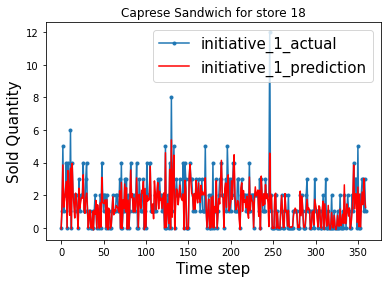

**********3000278: Breakfast Burrito Egg Beans & Rice**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


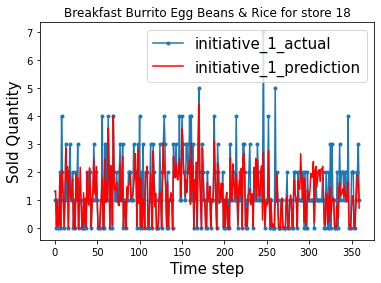

**********820602: Everything Bagel**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


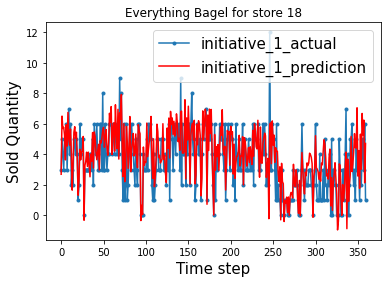

**********820801: Blueberry Scone**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


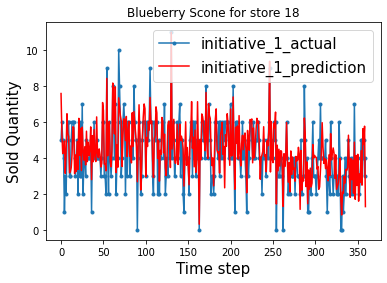

**********820902: Butter Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


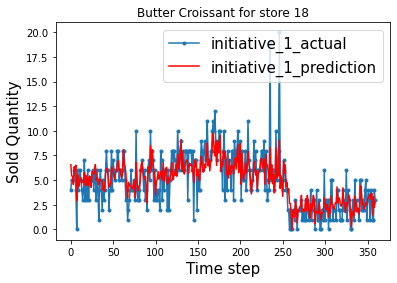

**********820224: Chocolate Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


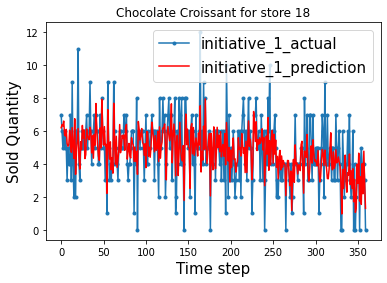

**********810703: Cinnamon Roll**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


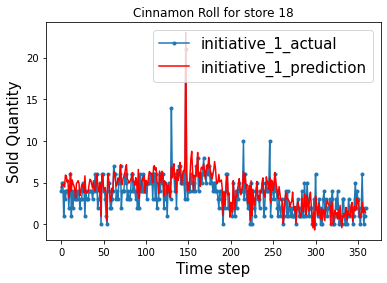

**********3000210: Cookie - Chocolate Chunk**************
time series data shape is:  (307, 64)
feature_X.shape, y.shape:  (307, 1, 63) (307,)


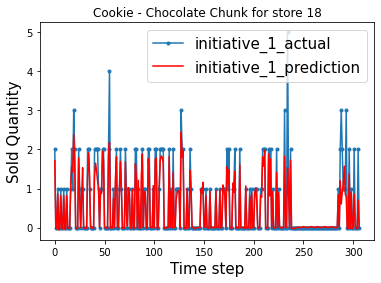

**********3000159: Egg| Spinach & Cheddar Sandwich on Ciabatta**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


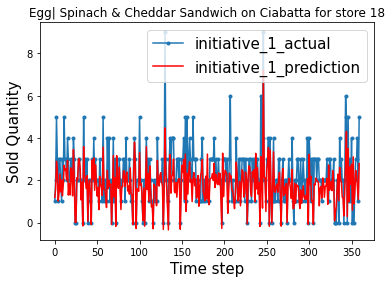

**********3000207: Danish - Classic Cheese**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


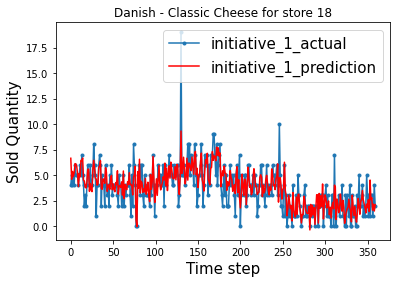

**********3000209: Croissant - White Cheddar Jalapeno**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


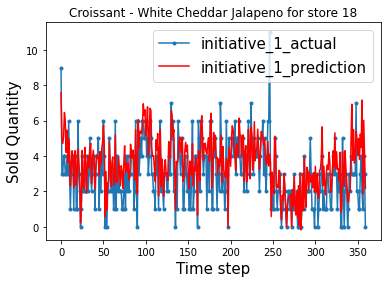

**********3000214: Coffee Cake with Streusel**************
time series data shape is:  (333, 64)
feature_X.shape, y.shape:  (333, 1, 63) (333,)


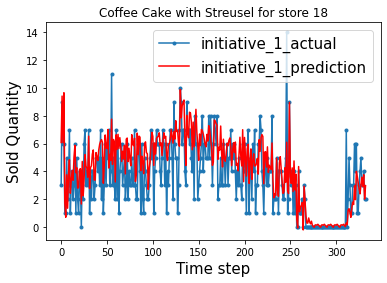

**********841402: Almond Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


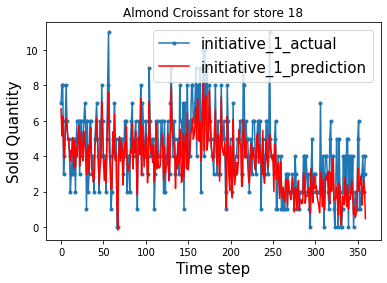

all 13 products prediction is done.


In [ ]:
# predict

for i, df_product in enumerate(dfs):

  print(f"**********{product_codes[i]}: {PLU_description[i]}**************")

  # split into train and test sets
  values = df_product.values
  reframed = series_to_supervised(values, 7, 1)
  print("time series data shape is: ", reframed.shape)

  values = reframed.values

  # data does not contain y (SoldQuantity), load model to predict
  X, y = values[:, :-1], values[:, -1]

  # reshaped input to be 3D [samples, timesteps, features]
  feature_X = X.reshape((X.shape[0], 1, X.shape[1]))

  print("feature_X.shape, y.shape: ", feature_X.shape, y.shape)

  # load model
  model = load_model(f'models_store_{STOREID}/{product_codes[i]}.h5')

  # maked a prediction
  yhat = model.predict(feature_X)

  index = df_product.index
  yhat2 = yhat.ravel()

  for j in range(len(index)):
    if j<7:
      df_sales_1.loc[index[j], 'PredictedSoldQuantity'] = df_product.loc[index[j], 'SoldQuantity']
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity1'] = df_product.loc[index[j], 'SoldQuantity']
    else:
      df_sales_1.loc[index[j], 'PredictedSoldQuantity'] = yhat2[j-7]
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity1'] = yhat2[j-7]

  ## time steps, every step is one hour (easily convert the time step to the actual time index)
  aa=[x for x in range(len(yhat))]
  plt.plot(aa, y, marker='.', label="initiative_1_actual")
  plt.plot(aa, yhat, 'r', label="initiative_1_prediction")
  plt.ylabel('Sold Quantity', size=15)
  plt.xlabel('Time step', size=15)
  plt.title(f"{PLU_description[i]} for store 18")
  plt.legend(fontsize=15)
  plt.show()

print("all 13 products prediction is done.")

## Business Initiative 2:
Initiative 2 follows the assumption of human defined ranges of what is hot weather and cold weather (<21 degress celsius for low and >26 degrees celsius for warm).  <br>
looking at is a "cold" product and the day is defined as warm, then we choose to increase the received quantity by 20% and adjust end quantity; If however, the product is cold and the day is cold, then we opt to decrease the received quantity by 10%, same goes for warm products during warm days. <br>
Read dataset for each individual store

This data is an estimated data based on the following method:
1. can rewrite the ReceivedQuantity feature based on each initiative, keep the SoldQuantity, re-calculate the EndQuantity, and apply your forecasting models. <br>
2. Business Initiative 1: increase the ReceivedQuantity for weekends and holidays

In [ ]:
import pandas as pd
df0 = pd.read_csv("dataset/3_store_clean_data_initiative2.csv")
df0

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,18,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,5.0,5.0,9,0,2,0,0,1.0
1,18,2019-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,6.0,0.0,16,0,2,0,0,4.0
2,18,2019-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,8.0,0.0,16,0,2,0,0,6.0
3,18,2019-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,8.0,0.0,15,1,2,0,0,7.0
4,18,2019-06-29,820224,Chocolate Croissant,Food,Bake Case,Pastries,10.0,0.0,18,0,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,332,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,Food,Cold Case,Ready to Eat,0.0,0.0,16,0,1,1,0,6.0
14002,332,2020-06-29,3000207,Danish - Classic Cheese,Food,Bake Case,Pastries,0.0,0.0,7,1,1,1,0,6.0
14003,332,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,Food,Bake Case,Pastries,0.0,1.0,17,0,1,1,0,1.0
14004,332,2020-06-29,3000214,Coffee Cake with Streusel,Food,Bake Case,Cakes & Breads,0.0,5.0,18,0,1,1,0,10.0


In [ ]:
df2 = df0[df0['StoreID'] == STOREID]
# products assigned to group 1
product_codes = [3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402]
df = df2[df2['PLU'].isin(product_codes)]
df

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,18,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,5.0,5.0,9,0,2,0,0,1.0
1,18,2019-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,6.0,0.0,16,0,2,0,0,4.0
2,18,2019-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,8.0,0.0,16,0,2,0,0,6.0
3,18,2019-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,8.0,0.0,15,1,2,0,0,7.0
4,18,2019-06-29,820224,Chocolate Croissant,Food,Bake Case,Pastries,10.0,0.0,18,0,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,Food,Cold Case,Ready to Eat,0.0,0.0,10,0,1,1,0,5.0
4683,18,2020-06-29,3000207,Danish - Classic Cheese,Food,Bake Case,Pastries,0.0,1.0,16,0,1,1,0,2.0
4684,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,Food,Bake Case,Pastries,0.0,1.0,0,0,1,1,0,0.0
4685,18,2020-06-29,3000214,Coffee Cake with Streusel,Food,Bake Case,Cakes & Breads,0.0,1.0,12,0,1,1,0,2.0


understand the list of products, total 13 products.

In [ ]:
df['PLU'].unique()

array([3000227,  820602,  820801,  820902,  820224,  810703, 3000210,
       3000159, 3000207, 3000209, 3000214,  841402])

In [ ]:
# SoldQuantity in a separate dataframe
df_SoldQuantity = df['SoldQuantity']

df2 = df.drop(['StoreID', 'BusinessDate', 'Description', 'CategoryLvl1Desc', 'CategoryLvl2Desc', 'CategoryLvl3Desc'], axis=1)
df2

,PLU,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,3000227,5.0,5.0,9,0,2,0,0,1.0
1,820602,6.0,0.0,16,0,2,0,0,4.0
2,820801,8.0,0.0,16,0,2,0,0,6.0
3,820902,8.0,0.0,15,1,2,0,0,7.0
4,820224,10.0,0.0,18,0,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...
4682,3000159,0.0,0.0,10,0,1,1,0,5.0
4683,3000207,0.0,1.0,16,0,1,1,0,2.0
4684,3000209,0.0,1.0,0,0,1,1,0,0.0
4685,3000214,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
df_SoldQuantity

0       1.0
1       4.0
2       6.0
3       7.0
4       3.0
       ... 
4682    5.0
4683    2.0
4684    0.0
4685    2.0
4686    4.0
Name: SoldQuantity, Length: 4324, dtype: float64

Use the trained LSTM model to predict on the Initiative1 data to get the predicted Sales.

In [ ]:
product_codes = df['PLU'].unique()
product_codes

array([3000227,  820602,  820801,  820902,  820224,  810703, 3000210,
       3000159, 3000207, 3000209, 3000214,  841402])

In [ ]:
PLU_description = df['Description'].unique()
PLU_description

array(['Caprese Sandwich', 'Everything Bagel', 'Blueberry Scone',
       'Butter Croissant', 'Chocolate Croissant', 'Cinnamon Roll',
       'Cookie - Chocolate Chunk',
       'Egg| Spinach & Cheddar Sandwich on Ciabatta',
       'Danish - Classic Cheese', 'Croissant - White Cheddar Jalapeno',
       'Coffee Cake with Streusel', 'Almond Croissant'], dtype=object)

In [ ]:
# created a new dataframe to collect all necessary sales estimated and predicted data
# named it as df_sales
df_sales_2 = df.loc[:,['StoreID', 'BusinessDate', 'PLU', 'Description', 'ReceivedQuantity', 'EndQuantity', 'SoldQuantity']]
df_sales_2

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity
0,18,2019-06-29,3000227,Caprese Sandwich,5.0,5.0,1.0
1,18,2019-06-29,820602,Everything Bagel,6.0,0.0,4.0
2,18,2019-06-29,820801,Blueberry Scone,8.0,0.0,6.0
3,18,2019-06-29,820902,Butter Croissant,8.0,0.0,7.0
4,18,2019-06-29,820224,Chocolate Croissant,10.0,0.0,3.0
...,...,...,...,...,...,...,...
4682,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0
4683,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0
4684,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0
4685,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0


In [ ]:
# Created dataframe for each product
def create_dfs(product_codes):
  dfs = []
  for code in product_codes:
    dfname = "df_" + str(code)
    dfname = df2[df2['PLU'] == code]
    dfname = dfname.drop('PLU', axis=1)
    dfs.append(dfname)
  return dfs

In [ ]:
dfs = create_dfs(product_codes)

Let's look at each product dataframe

In [ ]:
dfs[0]

,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,5.0,5.0,9,0,2,0,0,1.0
12,2.0,2.0,0,0,3,0,0,0.0
24,6.0,6.0,18,0,1,1,0,2.0
36,2.0,0.0,16,0,5,1,0,4.0
47,2.0,1.0,20,0,6,1,0,2.0
...,...,...,...,...,...,...,...,...
4622,0.0,0.0,12,1,4,1,0,3.0
4635,6.0,3.0,11,0,0,1,0,3.0
4648,0.0,0.0,15,1,2,0,0,1.0
4661,5.0,2.0,14,0,3,0,0,3.0


Predict

In [ ]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
	"""
	n_in: number of features to predict
	n_out: number of label to predict
	dropnan: if NaN, drop it or not
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


**********3000227: Caprese Sandwich**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


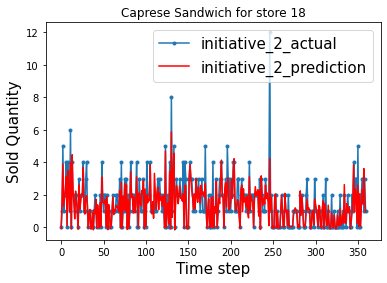

**********820602: Everything Bagel**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


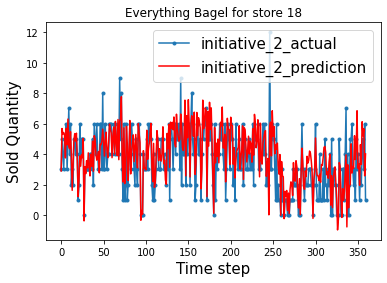

**********820801: Blueberry Scone**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


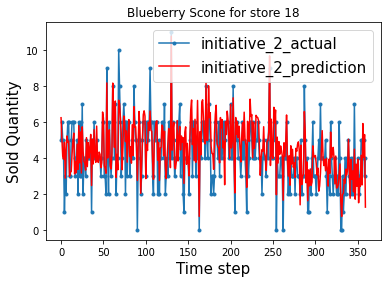

**********820902: Butter Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


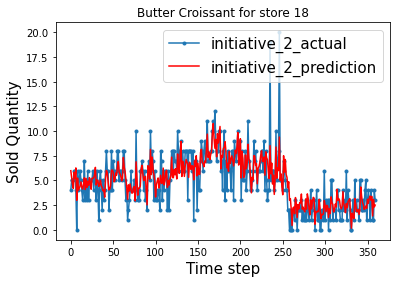

**********820224: Chocolate Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


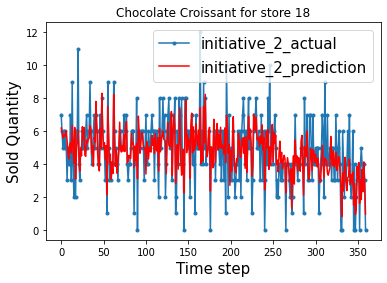

**********810703: Cinnamon Roll**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


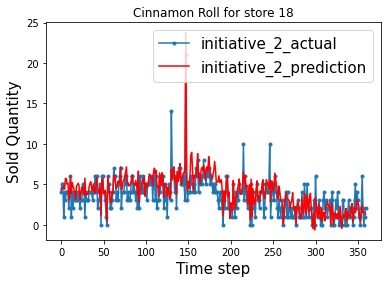

**********3000210: Cookie - Chocolate Chunk**************
time series data shape is:  (307, 64)
feature_X.shape, y.shape:  (307, 1, 63) (307,)


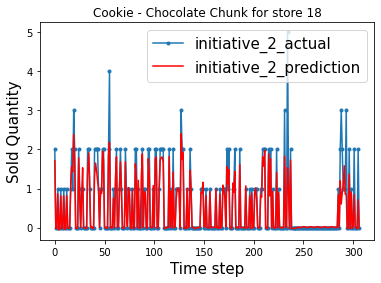

**********3000159: Egg| Spinach & Cheddar Sandwich on Ciabatta**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


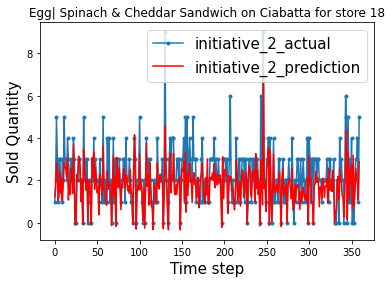

**********3000207: Danish - Classic Cheese**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


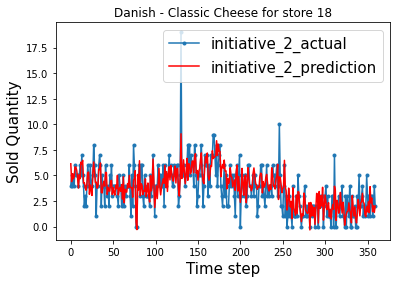

**********3000209: Croissant - White Cheddar Jalapeno**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


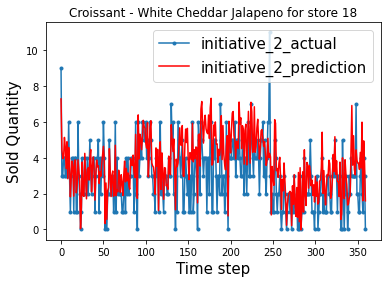

**********3000214: Coffee Cake with Streusel**************
time series data shape is:  (333, 64)
feature_X.shape, y.shape:  (333, 1, 63) (333,)


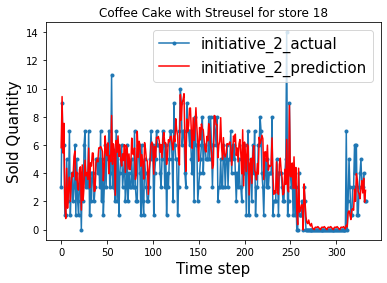

**********841402: Almond Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


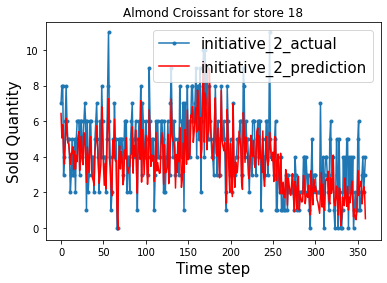

all 13 products prediction is done.


In [ ]:
from keras.models import load_model

for i, df_product in enumerate(dfs):

  print(f"**********{product_codes[i]}: {PLU_description[i]}**************")

  # split into train and test sets
  values = df_product.values
  reframed = series_to_supervised(values, 7, 1)
  print("time series data shape is: ", reframed.shape)

  values = reframed.values

  # data does not contain y (SoldQuantity), load model to predict
  X, y = values[:, :-1], values[:, -1]

  # reshaped input to be 3D [samples, timesteps, features]
  feature_X = X.reshape((X.shape[0], 1, X.shape[1]))

  print("feature_X.shape, y.shape: ", feature_X.shape, y.shape)

  # load the pre-trained model
  model = load_model(f'models_store_{STOREID}/{product_codes[i]}.h5')

  # maked a prediction
  yhat = model.predict(feature_X)

  index = df_product.index
  yhat2 = yhat.ravel()

  for j in range(len(index)):
    if j<7:
      df_sales_2.loc[index[j], 'PredictedSoldQuantity'] = df_product.loc[index[j], 'SoldQuantity']
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity3'] = df_product.loc[index[j], 'SoldQuantity']
    else:
      df_sales_2.loc[index[j], 'PredictedSoldQuantity'] = yhat2[j-7]
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity3'] = yhat2[j-7]

  ## time steps, every step is one hour (easily convert the time step to the actual time index)
  aa=[x for x in range(len(yhat))]
  plt.plot(aa, y, marker='.', label="initiative_2_actual")
  plt.plot(aa, yhat, 'r', label="initiative_2_prediction")
  plt.ylabel('Sold Quantity', size=15)
  plt.xlabel('Time step', size=15)
  plt.title(f"{PLU_description[i]} for store 18")
  plt.legend(fontsize=15)
  plt.show()

print("all 13 products prediction is done.")

In [ ]:
df_sales_2

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity,PredictedSoldQuantity
0,18,2019-06-29,3000227,Caprese Sandwich,5.0,5.0,1.0,1.000000
1,18,2019-06-29,820602,Everything Bagel,6.0,0.0,4.0,4.000000
2,18,2019-06-29,820801,Blueberry Scone,8.0,0.0,6.0,6.000000
3,18,2019-06-29,820902,Butter Croissant,8.0,0.0,7.0,7.000000
4,18,2019-06-29,820224,Chocolate Croissant,10.0,0.0,3.0,3.000000
...,...,...,...,...,...,...,...,...
4682,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0,2.882278
4683,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0,2.009482
4684,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0,1.599229
4685,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0,2.782134


In [ ]:
df_sales_2.to_csv(f"dataset/df_sales_initiative_2_store{STOREID}.csv", index=False)
df_sales.to_csv(f"dataset/df_sales_store{STOREID}.csv", index=False)

## Business Initiative 3:
Initiative 3 is applying a flat 20% increase across all products in received quantity, and increasing End Quantity accordingly. <br>
Read dataset for each individual store

This data is an estimated data based on the following method:
1. can rewrite the ReceivedQuantity feature based on each initiative, keep the SoldQuantity, re-calculate the EndQuantity, and apply your forecasting models. <br>
2. Business Initiative 1: increase the ReceivedQuantity for weekends and holidays

In [ ]:
import pandas as pd
df0 = pd.read_csv("dataset/all_store_clean_data_initiative3.csv")
df0


,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
0,2,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,0.0,0.0,21,0,2,0,0,3.0
1,2,2019-06-29,830620,Honey Raisin Bran Muffin,Food,Bake Case,Muffins & Scones,5.0,1.0,10,0,2,0,0,2.0
2,2,2019-06-29,6228,Pressed Juicery Spicy Greens w Ginger,Food,Cold Case,Ready to Drink,0.0,9.0,13,0,2,0,0,1.0
3,2,2019-06-29,12216,Vive Juice Shot,Food,Cold Case,Ready to Drink,0.0,27.0,0,0,2,0,0,0.0
4,2,2019-06-29,3000277,Mixed Berries & Granola Yogurt Parfait,Food,Cold Case,Ready to Eat,0.0,0.0,11,1,2,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259771,401,2020-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,7.0,4.0,0,0,1,1,0,3.0
1259772,401,2020-06-29,810407,Plain Bagel,Food,Bake Case,Bagels,7.0,1.0,0,1,1,1,0,6.0
1259773,401,2020-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,5.0,1.0,0,0,1,1,0,2.0
1259774,401,2020-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,7.0,1.0,0,0,1,1,0,3.0


In [ ]:
df2 = df0[df0['StoreID'] == STOREID]
# products assigned to group 1
product_codes = [3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402]
df = df2[df2['PLU'].isin(product_codes)]
df

,StoreID,BusinessDate,PLU,Description,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,Food,Cold Case,Ready to Eat,5.0,5.0,9,0,2,0,0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,Food,Cold Case,Ready to Eat,1.0,1.0,21,0,2,0,0,2.0
39468,18,2019-06-29,820602,Everything Bagel,Food,Bake Case,Bagels,7.0,1.0,16,0,2,0,0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,Food,Bake Case,Muffins & Scones,10.0,2.0,16,0,2,0,0,6.0
39471,18,2019-06-29,820902,Butter Croissant,Food,Bake Case,Pastries,10.0,2.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,Food,Cold Case,Ready to Eat,0.0,0.0,10,0,1,1,0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,Food,Bake Case,Pastries,0.0,1.0,16,0,1,1,0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,Food,Bake Case,Pastries,0.0,1.0,0,0,1,1,0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,Food,Bake Case,Cakes & Breads,0.0,1.0,12,0,1,1,0,2.0


understand the list of products, total 13 products.

In [ ]:
df['PLU'].unique()

array([3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402])

In [ ]:
# SoldQuantity in a separate dataframe
df_SoldQuantity = df['SoldQuantity']

df2 = df.drop(['StoreID', 'BusinessDate', 'Description', 'CategoryLvl1Desc', 'CategoryLvl2Desc', 'CategoryLvl3Desc'], axis=1)
df2

,PLU,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,3000227,5.0,5.0,9,0,2,0,0,1.0
39466,3000278,1.0,1.0,21,0,2,0,0,2.0
39468,820602,7.0,1.0,16,0,2,0,0,4.0
39470,820801,10.0,2.0,16,0,2,0,0,6.0
39471,820902,10.0,2.0,15,1,2,0,0,7.0
...,...,...,...,...,...,...,...,...,...
49760,3000159,0.0,0.0,10,0,1,1,0,5.0
49763,3000207,0.0,1.0,16,0,1,1,0,2.0
49764,3000209,0.0,1.0,0,0,1,1,0,0.0
49767,3000214,0.0,1.0,12,0,1,1,0,2.0


In [ ]:
df_SoldQuantity

39461    1.0
39466    2.0
39468    4.0
39470    6.0
39471    7.0
        ... 
49760    5.0
49763    2.0
49764    0.0
49767    2.0
49769    4.0
Name: SoldQuantity, Length: 4691, dtype: float64

Use the trained LSTM model to predict on the Initiative1 data to get the predicted Sales.

In [ ]:
product_codes = df['PLU'].unique()
product_codes

array([3000227, 3000278,  820602,  820801,  820902,  820224,  810703,
       3000210, 3000159, 3000207, 3000209, 3000214,  841402])

In [ ]:
PLU_description = df['Description'].unique()
PLU_description

array(['Caprese Sandwich', 'Breakfast Burrito Egg Beans & Rice',
       'Everything Bagel', 'Blueberry Scone', 'Butter Croissant',
       'Chocolate Croissant', 'Cinnamon Roll', 'Cookie - Chocolate Chunk',
       'Egg| Spinach & Cheddar Sandwich on Ciabatta',
       'Danish - Classic Cheese', 'Croissant - White Cheddar Jalapeno',
       'Coffee Cake with Streusel', 'Almond Croissant'], dtype=object)

In [ ]:
# created a new dataframe to collect all necessary sales estimated and predicted data
# named it as df_sales
df_sales_3 = df.loc[:,['StoreID', 'BusinessDate', 'PLU', 'Description', 'ReceivedQuantity', 'EndQuantity', 'SoldQuantity']]
df_sales_3

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,5.0,5.0,1.0
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,1.0,1.0,2.0
39468,18,2019-06-29,820602,Everything Bagel,7.0,1.0,4.0
39470,18,2019-06-29,820801,Blueberry Scone,10.0,2.0,6.0
39471,18,2019-06-29,820902,Butter Croissant,10.0,2.0,7.0
...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0
49763,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0


In [ ]:
# Created dataframe for each product
def create_dfs(product_codes):
  dfs = []
  for code in product_codes:
    dfname = "df_" + str(code)
    dfname = df2[df2['PLU'] == code]
    dfname = dfname.drop('PLU', axis=1)
    dfs.append(dfname)
  return dfs

In [ ]:
dfs = create_dfs(product_codes)

Let's look at each product dataframe

In [ ]:
dfs[0]

,ReceivedQuantity,EndQuantity,LatestOrder,StockedOut,Days,Weekday,NationalHoliday,SoldQuantity
39461,5.0,5.0,9,0,2,0,0,1.0
39488,2.0,2.0,0,0,3,0,0,0.0
39515,6.0,6.0,18,0,1,1,0,2.0
39541,2.0,0.0,16,0,5,1,0,4.0
39566,2.0,1.0,20,0,6,1,0,2.0
...,...,...,...,...,...,...,...,...
49621,0.0,0.0,12,1,4,1,0,3.0
49650,6.0,3.0,11,0,0,1,0,3.0
49679,0.0,0.0,15,1,2,0,0,1.0
49709,6.0,3.0,14,0,3,0,0,3.0


Predict

In [ ]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
	"""
	n_in: number of features to predict
	n_out: number of label to predict
	dropnan: if NaN, drop it or not
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


**********3000227: Caprese Sandwich**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


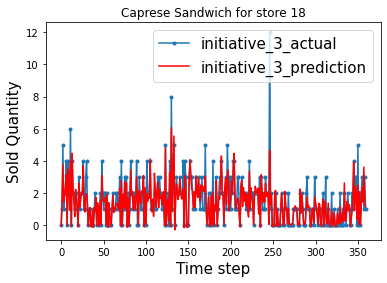

**********3000278: Breakfast Burrito Egg Beans & Rice**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


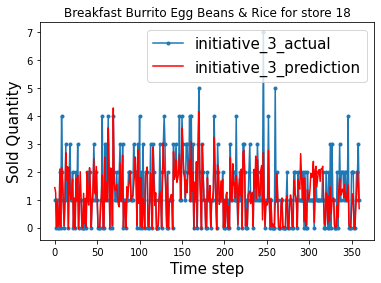

**********820602: Everything Bagel**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


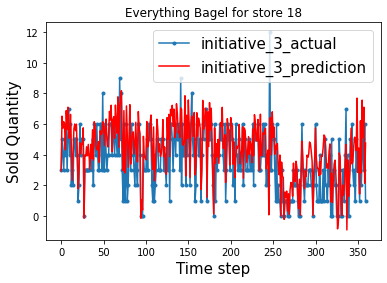

**********820801: Blueberry Scone**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


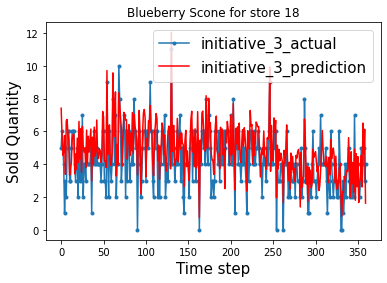

**********820902: Butter Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


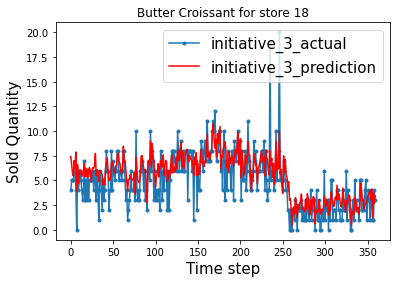

**********820224: Chocolate Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


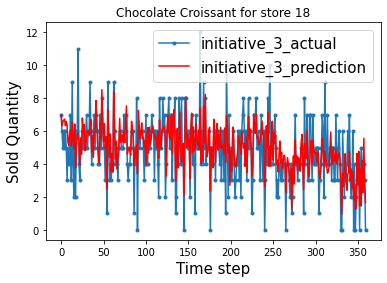

**********810703: Cinnamon Roll**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


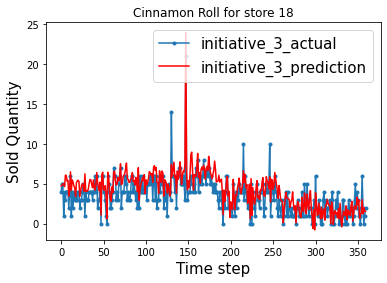

**********3000210: Cookie - Chocolate Chunk**************
time series data shape is:  (307, 64)
feature_X.shape, y.shape:  (307, 1, 63) (307,)


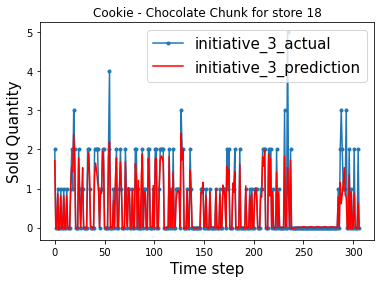

**********3000159: Egg| Spinach & Cheddar Sandwich on Ciabatta**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


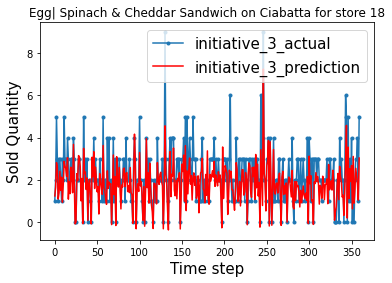

**********3000207: Danish - Classic Cheese**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


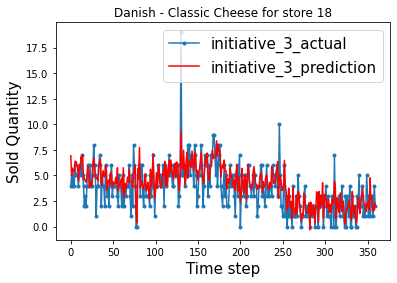

**********3000209: Croissant - White Cheddar Jalapeno**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


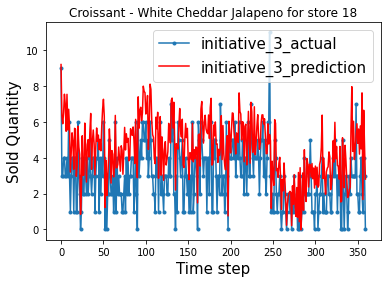

**********3000214: Coffee Cake with Streusel**************
time series data shape is:  (333, 64)
feature_X.shape, y.shape:  (333, 1, 63) (333,)


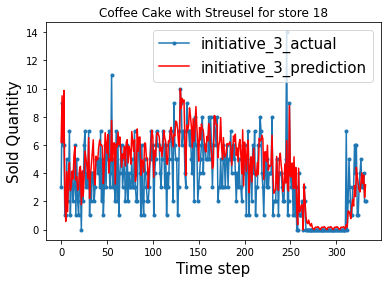

**********841402: Almond Croissant**************
time series data shape is:  (360, 64)
feature_X.shape, y.shape:  (360, 1, 63) (360,)


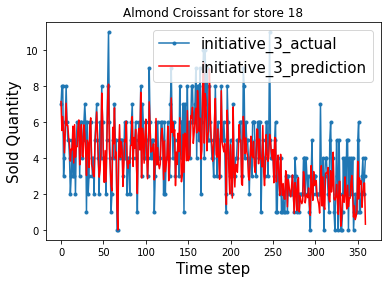

all 13 products prediction is done.


In [ ]:
from keras.models import load_model

for i, df_product in enumerate(dfs):

  print(f"**********{product_codes[i]}: {PLU_description[i]}**************")

  # splited into train and test sets
  values = df_product.values
  reframed = series_to_supervised(values, 7, 1)
  print("time series data shape is: ", reframed.shape)

  values = reframed.values

  # data does not contain y (SoldQuantity), load model to predict
  X, y = values[:, :-1], values[:, -1]

  # reshaped input to be 3D [samples, timesteps, features]
  feature_X = X.reshape((X.shape[0], 1, X.shape[1]))

  print("feature_X.shape, y.shape: ", feature_X.shape, y.shape)

  # loaded the pre-trained model
  model = load_model(f'models_store_{STOREID}/{product_codes[i]}.h5')

  # maked a prediction
  yhat = model.predict(feature_X)

  index = df_product.index
  yhat2 = yhat.ravel()

  for j in range(len(index)):
    if j<7:
      df_sales_3.loc[index[j], 'PredictedSoldQuantity'] = df_product.loc[index[j], 'SoldQuantity']
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity3'] = df_product.loc[index[j], 'SoldQuantity']
    else:
      df_sales_3.loc[index[j], 'PredictedSoldQuantity'] = yhat2[j-7]
      df_sales.loc[index[j], 'PredictedEstimatedSoldQuantity3'] = yhat2[j-7]

  ## time steps, every step is one hour (easily convert the time step to the actual time index)
  aa=[x for x in range(len(yhat))]
  plt.plot(aa, y, marker='.', label="initiative_3_actual")
  plt.plot(aa, yhat, 'r', label="initiative_3_prediction")
  plt.ylabel('Sold Quantity', size=15)
  plt.xlabel('Time step', size=15)
  plt.title(f"{PLU_description[i]} for store 18")
  plt.legend(fontsize=15)
  plt.show()

print("all 13 products prediction is done.")

In [ ]:
df_sales_3

,StoreID,BusinessDate,PLU,Description,ReceivedQuantity,EndQuantity,SoldQuantity,PredictedSoldQuantity
39461,18,2019-06-29,3000227,Caprese Sandwich,5.0,5.0,1.0,1.000000
39466,18,2019-06-29,3000278,Breakfast Burrito Egg Beans & Rice,1.0,1.0,2.0,2.000000
39468,18,2019-06-29,820602,Everything Bagel,7.0,1.0,4.0,4.000000
39470,18,2019-06-29,820801,Blueberry Scone,10.0,2.0,6.0,6.000000
39471,18,2019-06-29,820902,Butter Croissant,10.0,2.0,7.0,7.000000
...,...,...,...,...,...,...,...,...
49760,18,2020-06-29,3000159,Egg| Spinach & Cheddar Sandwich on Ciabatta,0.0,0.0,5.0,3.030839
49763,18,2020-06-29,3000207,Danish - Classic Cheese,0.0,1.0,2.0,2.274603
49764,18,2020-06-29,3000209,Croissant - White Cheddar Jalapeno,0.0,1.0,0.0,2.808542
49767,18,2020-06-29,3000214,Coffee Cake with Streusel,0.0,1.0,2.0,3.172602


In [ ]:
df_sales_3.to_csv(f"dataset/df_sales_initiative_3_store{STOREID}.csv", index=False)
df_sales.to_csv(f"dataset/df_sales_store{STOREID}.csv", index=False)

## Plot sales increase across three inventory *initiatives*

Understand the overall accumulated sales for all initiatives, including the original coffee store sales.

In [ ]:
# df_sales_0 = pd.read_csv("dataset/df_sales_original_store18.csv")
# df_sales_1 = pd.read_csv("dataset/df_sales_initiative_1_store18.csv")
# df_sales_3 = pd.read_csv("dataset/df_sales_initiative_3_store18.csv")
df_sales = pd.read_csv(f'dataset/df_sales_store{STOREID}.csv')

In [ ]:
# unique products (codes and names)

product_codes = df_current_store['PLU'].unique()
print("product_codes: " , product_codes)

PLU_description = df_current_store['Description'].unique()
print("PLU_description: ", PLU_description)

product_codes:  [3000227 3000278  820602  820801  820902  820224  810703 3000210 3000159
 3000207 3000209 3000214  841402]
PLU_description:  ['Caprese Sandwich' 'Breakfast Burrito Egg Beans & Rice'
 'Everything Bagel' 'Blueberry Scone' 'Butter Croissant'
 'Chocolate Croissant' 'Cinnamon Roll' 'Cookie - Chocolate Chunk'
 'Egg| Spinach & Cheddar Sandwich on Ciabatta' 'Danish - Classic Cheese'
 'Croissant - White Cheddar Jalapeno' 'Coffee Cake with Streusel'
 'Almond Croissant']


Total sales for each inventory initiative per product for this store.

In [ ]:
from collections import defaultdict
sales_dict = defaultdict(list)
for i, code in enumerate(product_codes):
  df_current_product = df_sales[df_sales['PLU'] == code]
  sum_sold = sum(df_sales['SoldQuantity'])
  sum_predictedEstimated1 = sum(df_sales['PredictedEstimatedSoldQuantity1'])
  sum_predictedEstimated3 = sum(df_sales['PredictedEstimatedSoldQuantity3'])
  sales_dict[PLU_description[i]].append((sum_sold, sum_predictedEstimated1, sum_predictedEstimated3))

sales_dict

defaultdict(list,
            {'Almond Croissant': [(nan, nan, 31811.31962325261)],
             'Blueberry Scone': [(nan, nan, 31811.31962325261)],
             'Breakfast Burrito Egg Beans & Rice': [(nan,
               nan,
               31811.31962325261)],
             'Butter Croissant': [(nan, nan, 31811.31962325261)],
             'Caprese Sandwich': [(nan, nan, 31811.31962325261)],
             'Chocolate Croissant': [(nan, nan, 31811.31962325261)],
             'Cinnamon Roll': [(nan, nan, 31811.31962325261)],
             'Coffee Cake with Streusel': [(nan, nan, 31811.31962325261)],
             'Cookie - Chocolate Chunk': [(nan, nan, 31811.31962325261)],
             'Croissant - White Cheddar Jalapeno': [(nan,
               nan,
               31811.31962325261)],
             'Danish - Classic Cheese': [(nan, nan, 31811.31962325261)],
             'Egg| Spinach & Cheddar Sandwich on Ciabatta': [(nan,
               nan,
               31811.31962325261)],
             '

#### Function to calculate waste per each store
- analyzed the data and found that each product has its on-shelf life cycle various by days, found that the waste can be obtained by getting the difference between ReceivedQuantity and SoldQuantity during a period of time disregarding each product's on-shelf life cycle. <br>
- However, the waste data has to be obtained product by product. <br>

In [ ]:
def get_waste_sales(df):
  waste_by_products = {}
  total_waste, total_sales = 0, 0
  PLUs = df['PLU'].unique()
  products = df['Description'].unique()
  for i, product in enumerate(products):
    df_name = "df" + str(PLUs[i])
    df_name = df[df['Description'] == product]

    ReceivedQ = df_name['ReceivedQuantity'].values
    EndQ = df_name['EndQuantity'].values
    SoldQ = df_name['PredictedSoldQuantity'].values

    #tracked the last record in this whole period for EndQuantity
    #those are still in the stock (not thrown away)
    lastEndQ = EndQ[-1]
    sum_ReceivedQ = sum(ReceivedQ)
    sum_EndQ = sum(EndQ)
    sum_SoldQ = sum(SoldQ)
    waste = sum_ReceivedQ - sum_SoldQ - lastEndQ
    total_waste += waste

    #accumulated total sales for all product for this store
    total_sales += sum_SoldQ

    #save the waste and sales per product to a dictionary
    waste_by_products[product] = (waste, sum_SoldQ)

  return total_waste, total_sales, waste_by_products

Analyze cost per inventory initiative.

Original coffee store waste and sales analysis

In [ ]:
# Read sales data for all initiatives including the original sales data
# df_sales_0 = pd.read_csv(f"dataset/df_sales_original_store{STOREID}.csv")
# df_sales_1 = pd.read_csv(f"dataset/df_sales_initiative_1_store{STOREID}.csv")
# df_sales_3 = pd.read_csv(f"dataset/df_sales_initiative_3_store{STOREID}.csv")

# Original coffee store (without applying initiative) waste and sales
total_waste_0, total_sales_0, waste_by_products_0 = get_waste_sales(df_sales_0)
print("Original coffee store's total waste: ", total_waste_0)
print("Original coffee store's total sales: ", total_sales_0)
print("Original coffee store's waste and sales per product")
print(waste_by_products_0)


# Initiative 1's waste and sales
total_waste_1, total_sales_1, waste_by_products_1 = get_waste_sales(df_sales_1)
print("Initiative 1's total waste: ", total_waste_1)
print("Initiative 1's total sales: ", total_sales_1)
print("Initiative 1's waste and sales per product")
print(waste_by_products_1)

# Initiative 1's waste and sales
total_waste_2, total_sales_2, waste_by_products_2 = get_waste_sales(df_sales_2)
print("Initiative 1's total waste: ", total_waste_2)
print("Initiative 1's total sales: ", total_sales_2)
print("Initiative 1's waste and sales per product")
print(waste_by_products_2)

# Initiative 3's waste and sales
total_waste_3, total_sales_3, waste_by_products_3 = get_waste_sales(df_sales_3)
print("Initiative 3's total waste: ", total_waste_3)
print("Initiative 3's total sales: ", total_sales_3)
print("Initiative 3's waste and sales per product")
print(waste_by_products_3)

Original coffee store's total waste:  6442.6994271307485
Original coffee store's total sales:  14794.300572869251
Original coffee store's waste and sales per product
{'Caprese Sandwich': (286.92316770914476, 497.07683229085524), 'Breakfast Burrito Egg Beans & Rice': (276.3734616083093, 437.6265383916907), 'Everything Bagel': (594.1756779477, 1376.8243220523), 'Blueberry Scone': (433.5123761370778, 1576.4876238629222), 'Butter Croissant': (683.4389168173075, 1711.5610831826925), 'Chocolate Croissant': (539.828452706337, 1695.171547293663), 'Cinnamon Roll': (359.30915573239326, 1450.6908442676067), 'Cookie - Chocolate Chunk': (336.2305331833195, 155.7694668166805), 'Egg| Spinach & Cheddar Sandwich on Ciabatta': (303.99031486175954, 649.0096851382405), 'Danish - Classic Cheese': (561.2755892649293, 1351.7244107350707), 'Croissant - White Cheddar Jalapeno': (551.658244125545, 1179.341755874455), 'Coffee Cake with Streusel': (732.9793669320643, 1429.0206330679357), 'Almond Croissant': (783.

Cost Benefit Analysis

In [ ]:
wastes, revenues, profits = [], [], []
UNIT_COST, UNIT_PRICE = 0.5, 3
# original coffee store data
waste_0 = int(UNIT_COST * total_waste_0)
revenue_0 = int(UNIT_PRICE * total_sales_0)
profit_0 = int(revenue_0 - waste_0)

#initiative 1
waste_1 = int(UNIT_COST * total_waste_1)
revenue_1 = int(UNIT_PRICE * total_sales_1)
profit_1 = int(revenue_1 - waste_1)

#initiative 2
waste_2 = int(UNIT_COST * total_waste_2)
revenue_2 = int(UNIT_PRICE * total_sales_2)
profit_2 = int(revenue_2 - waste_2)

#initiative 3
waste_3 = int(UNIT_COST * total_waste_3)
revenue_3 = int(UNIT_PRICE * total_sales_3)
profit_3 = int(revenue_3 - waste_3)

wastes.append(waste_0)
wastes.append(waste_1)
wastes.append(waste_2)
wastes.append(waste_3)

revenues.append(revenue_0)
revenues.append(revenue_1)
revenues.append(revenue_2)
revenues.append(revenue_3)

profits.append(profit_0)
profits.append(profit_1)
profits.append(profit_2)
profits.append(profit_3)

print("original coffee store profit: $" , profit_0)
print("initiative 1 profit: $" , profit_1)
print("initiative 2 profit: $" , profit_2)
print("initiative 3 profit: $" , profit_3)

original coffee store profit: $ 41161
initiative 1 profit: $ 42744
initiative 2 profit: $ 41825
initiative 3 profit: $ 45805


In [ ]:
print(wastes)
print(revenues)
print(profits)

[3221, 3595, 3451, 4352]
[44382, 46339, 45276, 50157]
[41161, 42744, 41825, 45805]


Plot Cost-Benefit Chart across all initiatives

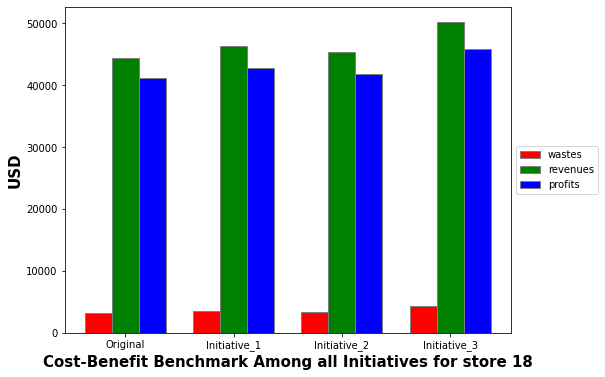

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6))

# Set position of bar on X axis
br1 = np.arange(len(wastes))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Maked the plot
plt.bar(br1, wastes, color ='r', width = barWidth,
		edgecolor ='grey', label ='wastes')
plt.bar(br2, revenues, color ='g', width = barWidth,
		edgecolor ='grey', label ='revenues')
plt.bar(br3, profits, color ='b', width = barWidth,
		edgecolor ='grey', label ='profits')

# Adding Xticks
plt.xlabel(f'Cost-Benefit Benchmark Among all Initiatives for store {STOREID}', fontweight ='bold', fontsize = 15)
plt.ylabel('USD', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(wastes))],
		['Original', 'Initiative_1', 'Initiative_2', 'Initiative_3'])

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


Plot wastes and sales by products

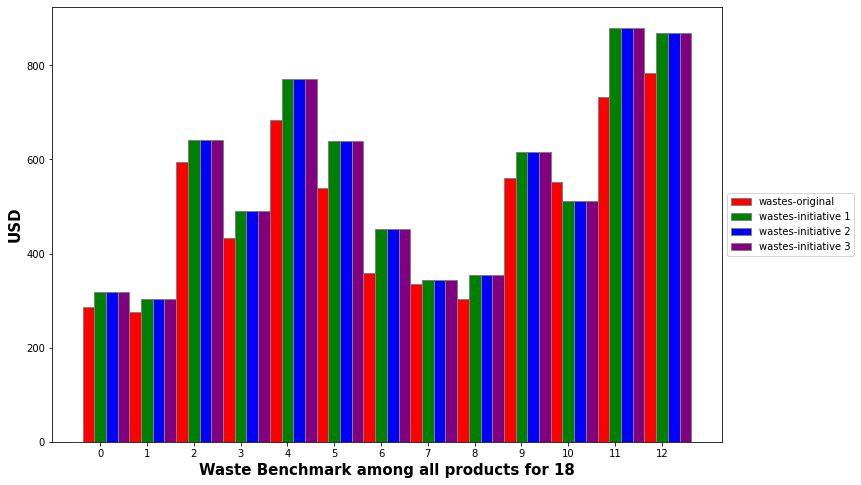

{0: 'Caprese Sandwich', 1: 'Breakfast Burrito Egg Beans & Rice', 2: 'Everything Bagel', 3: 'Blueberry Scone', 4: 'Butter Croissant', 5: 'Chocolate Croissant', 6: 'Cinnamon Roll', 7: 'Cookie - Chocolate Chunk', 8: 'Egg| Spinach & Cheddar Sandwich on Ciabatta', 9: 'Danish - Classic Cheese', 10: 'Croissant - White Cheddar Jalapeno', 11: 'Coffee Cake with Streusel', 12: 'Almond Croissant'}


In [ ]:
data0 = waste_by_products_0
names = list(data0.keys())
names_index = [i for i in range(len(names))]
values = list(data0.values())
values0 = [values[i][0] for i in range(len(values))]
values1 = [values[i][1] for i in range(len(values))]

data1 = waste_by_products_1
values = list(data1.values())
values2 = [values[i][0] for i in range(len(values))]
values3 = [values[i][1] for i in range(len(values))]

data2 = waste_by_products_2
values = list(data1.values())
values4 = [values[i][0] for i in range(len(values))]
values5 = [values[i][1] for i in range(len(values))]

data3 = waste_by_products_3
values = list(data1.values())
values6 = [values[i][0] for i in range(len(values))]
values7 = [values[i][1] for i in range(len(values))]

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(values))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, values0, color ='red', width = barWidth,
		edgecolor ='grey', label ='wastes-original')
plt.bar(br2, values2, color ='green', width = barWidth,
		edgecolor ='grey', label ='wastes-initiative 1')
plt.bar(br3, values4, color ='blue', width = barWidth,
		edgecolor ='grey', label ='wastes-initiative 2')
plt.bar(br4, values6, color ='purple', width = barWidth,
		edgecolor ='grey', label ='wastes-initiative 3')

# Adding Xticks
plt.xlabel(f'Waste Benchmark among all products for {STOREID}', fontweight ='bold', fontsize = 15)
plt.ylabel('USD', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(values1))],names_index)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

product_dict = dict(zip(names_index, names))
print(product_dict)

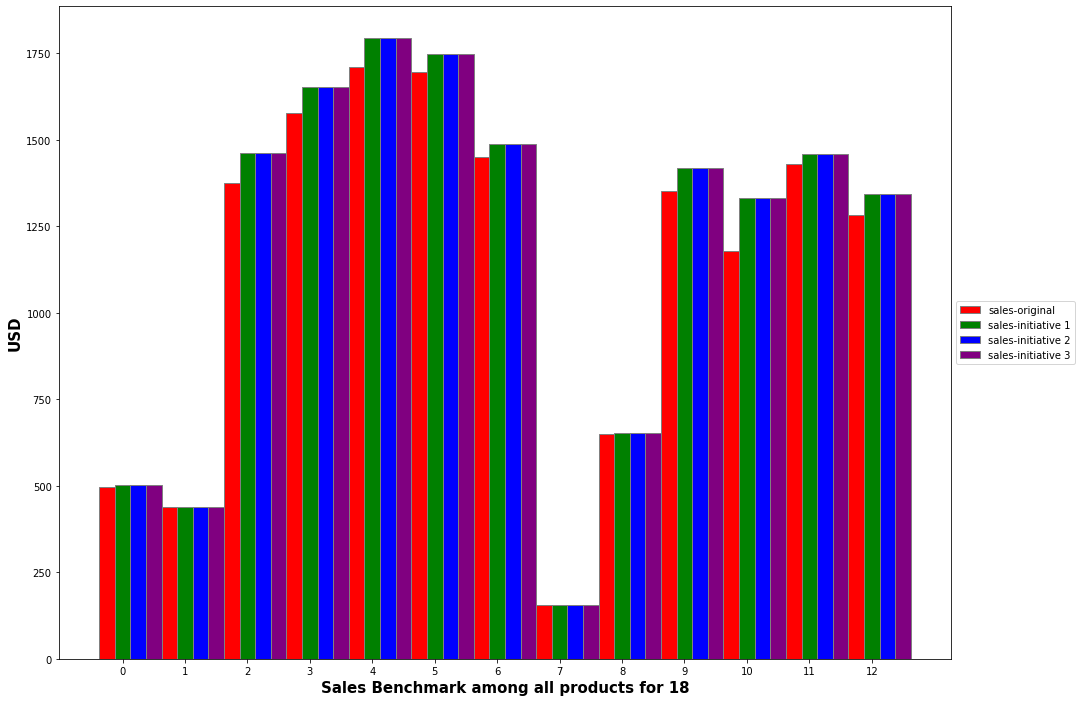

{0: 'Caprese Sandwich', 1: 'Breakfast Burrito Egg Beans & Rice', 2: 'Everything Bagel', 3: 'Blueberry Scone', 4: 'Butter Croissant', 5: 'Chocolate Croissant', 6: 'Cinnamon Roll', 7: 'Cookie - Chocolate Chunk', 8: 'Egg| Spinach & Cheddar Sandwich on Ciabatta', 9: 'Danish - Classic Cheese', 10: 'Croissant - White Cheddar Jalapeno', 11: 'Coffee Cake with Streusel', 12: 'Almond Croissant'}


In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(16, 12))

# Set position of bar on X axis
br1 = np.arange(len(values))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, values1, color ='red', width = barWidth,
		edgecolor ='grey', label ='sales-original')
plt.bar(br2, values3, color ='green', width = barWidth,
		edgecolor ='grey', label ='sales-initiative 1')
plt.bar(br3, values5, color ='blue', width = barWidth,
		edgecolor ='grey', label ='sales-initiative 2')
plt.bar(br4, values7, color ='purple', width = barWidth,
		edgecolor ='grey', label ='sales-initiative 3')

# Adding Xticks
plt.xlabel(f'Sales Benchmark among all products for {STOREID}', fontweight ='bold', fontsize = 15)
plt.ylabel('USD', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(values1))],names_index)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


product_dict = dict(zip(names_index, names))
print(product_dict)